[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


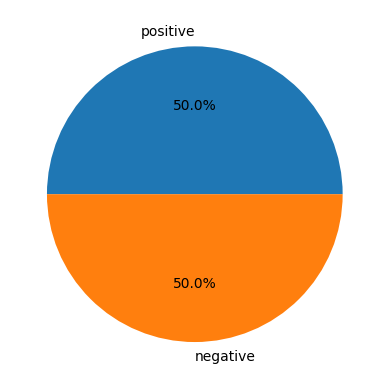

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00       294

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



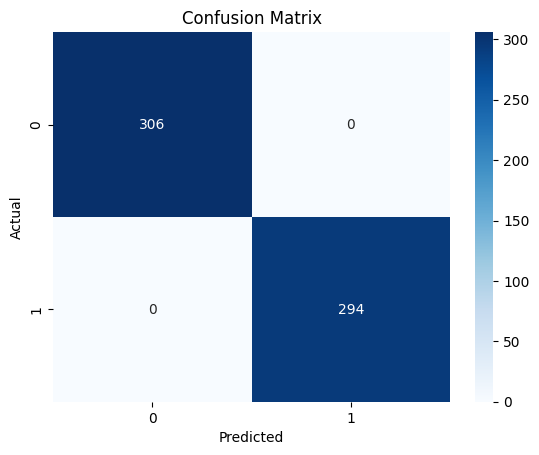

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af4bc21a944c296c91.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')

df = pd.read_csv('/content/reviews_dataset.csv')
df.head()

plt.pie(df["review"].value_counts(),labels=df["review"].unique(),autopct="%1.1f%%")
plt.show()

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['review_text'].astype(str).apply(preprocess)


tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


y = df['review']
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = MultinomialNB()
model.fit(X_train, y_train)


model.score(X_test, y_test)


y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


def analyze_sentiment(user_input):
    cleaned = preprocess(user_input)
    vector = tfidf.transform([cleaned])
    prediction = model.predict(vector)[0]
    sentiment_label = le.inverse_transform([prediction])[0]
    return f"Sentiment: {sentiment_label.upper()}"


interface = gr.Interface(
    fn=analyze_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter product review here..."),
    outputs="text",
    title="Sentiment Analysis App",
    description="Enter a product review. The model will predict whether it's GOOD or WORST."
)


interface.launch()